## Question 2: Bias by Label - Lindsey

Are the albums from one label rated differently than the wider population? In other words, does Pitchfork rate a certain record label more highly (or more harshly)
than others?

- *Alternative Hypothesis:* Average Pitchfork reviews are significantly different for one record label compared to the others.
- *Null Hypothesis:* Average Pitchfork reviews are not significantly different for different record labels.

In [1]:
# Imports

import sqlite3
import pandas as pd
import numpy as np
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import statsmodels as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
import operator

In [2]:
# Creating connection to SQL database

conn = sqlite3.Connection("database.sqlite")
c = conn.cursor()

In [3]:
# Querying for our review scores and record labels

c.execute("""SELECT score, 
                    label
             FROM labels
             JOIN reviews
             USING(reviewid);""")

# Creating a pandas dataframe from our SQLite query
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,score,label
0,9.3,virgin
1,7.9,hathenter
2,7.3,static shock
3,7.3,fashionable idiots
4,9.0,kill rock stars


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 2 columns):
score    20200 non-null float64
label    20162 non-null object
dtypes: float64(1), object(1)
memory usage: 315.7+ KB


In [5]:
# Since we are looking specifically at scores as they relate to record 
# labels, we need to drop the albums where there is no label data

# Dropping rows where label is null
df.dropna(inplace=True)

# There are also rows where label is blank, not null, so dropping those too
list_empty_labels = list(df.loc[df["label"] == ""].index)
df = df.drop(list_empty_labels)

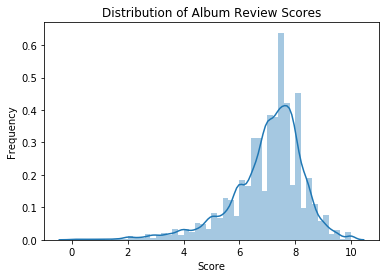

In [6]:
# Exploring the distribution of scores across all albums with label data
sns.distplot(df["score"])
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Album Review Scores")
plt.show()

In [7]:
# Initial descriptive statistics for all albums with label data
df.describe()

,score
count,20153.000000
mean,7.002923
std,1.304778
min,0.000000
25%,6.400000
50%,7.200000
75%,7.800000
max,10.000000


We can see that the average review across all albums with record label information is a 7. Now, the question is whether any of the average scores for a particular label is significantly different from that mean.

In [8]:
# Creating a new dataframe specifically looking at instances of our labels

# Creating a column for average scores
label_df = df.groupby("label").mean()[["score"]]
label_df.rename(columns={"score": "avg_score"}, inplace=True)

# Adding a column with the count of each label to our new label dataframe
label_df["count"] = df.groupby("label").count()[["score"]]

# Also adding a column with the standard deviation between the scores of each
# label, for later analysis
label_df["stdev"] = df.groupby("label").std()[["score"]]

label_df.head()

,avg_score,count,stdev
label,,,
deux,5.800000,1,NaN
!k7,6.943077,65,1.217191
+1,6.900000,3,0.953939
00:02:59,7.400000,1,NaN
1-2-3-4 go!,6.750000,2,1.343503


In [59]:
label_df.shape

(3666, 3)

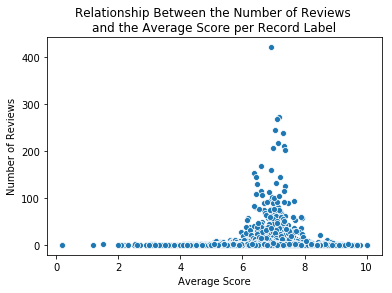

In [9]:
# Initial exploration: Examining the relationship between average review score 
# and number of reviews per record label

sns.scatterplot(x=label_df["avg_score"], y=label_df["count"])
plt.xlabel("Average Score")
plt.ylabel("Number of Reviews")
plt.title("Relationship Between the Number of Reviews \n"
          + "and the Average Score per Record Label")
plt.show()

In [10]:
# Examining the descriptive stats 
label_df.describe()

,avg_score,count,stdev
count,3666.000000,3666.000000,1637.000000
mean,6.992975,5.497272,0.935161
std,1.075392,17.986523,0.636676
min,0.200000,1.000000,0.000000
25%,6.500000,1.000000,0.463896
50%,7.166667,1.000000,0.820366
75%,7.700000,3.000000,1.272792
max,10.000000,420.000000,4.525483


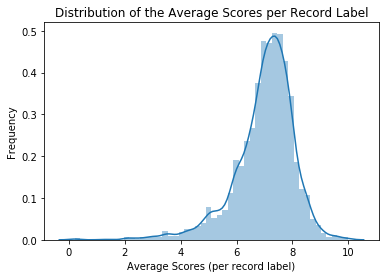

In [11]:
# Plotting the distribution of the average scores per record label

sns.distplot(label_df["avg_score"])
plt.xlabel("Average Scores (per record label)")
plt.ylabel("Frequency")
plt.title("Distribution of the Average Scores per Record Label")
plt.show()

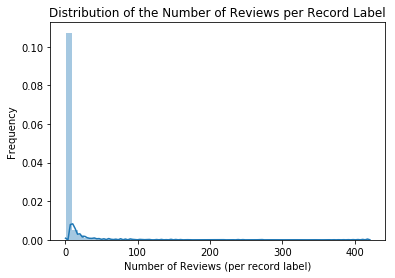

In [12]:
# Plotting the distribution of the number of reviews per record label

sns.distplot(label_df["count"])
plt.xlabel("Number of Reviews (per record label)")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Reviews per Record Label")
plt.show()

When we look at the description and distribution plot above, we can see that most of our record labels only have one review each. If we were to simply sort our record labels based on average review scores, we might falsely come to the conclusion that the reviewers at the top or bottom of the list are the best record labels according to Pitchfork.

To illustrate:

In [13]:
# Looking simply at the top of the list, the labels with the highest scores
label_df.sort_values("avg_score", ascending=False).head()

,avg_score,count,stdev
label,,,
rolling stones,10.0,1,NaN
geffen/get on down,10.0,1,NaN
enigma,10.0,1,NaN
volt,10.0,1,NaN
ace of hearts,9.8,1,NaN


In [14]:
# Looking simply at the bottom of the list, the labels with the lowest scores
label_df.sort_values("avg_score", ascending=True).head()

,avg_score,count,stdev
label,,,
mud,0.2,1,NaN
buddyhead,0.2,1,NaN
compadre,0.2,1,NaN
boojm,1.2,1,NaN
trashy moped,1.5,2,0.0


Note that all of the record labels with both the best and the worst scores have only one review. Does that truly mean that albums from those labels are rated differently than the rest of the record labels? Probably not!

Knowing that having just a few reviews is not enough information to work with, I'm going to cull the record labels to remove any who have fewer than five reviews, and see how this changes the distribution of my data.

In [15]:
# Making a new dataframe without labels with fewer than five reviews
# Note that this removes 2419 rows (labels)!

culled_label_df = label_df.loc[label_df["count"] >= 5]
culled_label_df.head()

,avg_score,count,stdev
label,,,
!k7,6.943077,65,1.217191
100% silk,7.112500,8,0.352288
1017 brick squad,7.157143,7,0.789213
12xu,7.760000,5,0.207364
130701,7.640000,5,1.272006


In [16]:
culled_label_df.describe()

,avg_score,count,stdev
count,670.000000,670.000000,670.000000
mean,7.008527,23.367164,1.104683
std,0.576928,37.120047,0.492636
min,5.085714,5.000000,0.044721
25%,6.655625,6.000000,0.742630
50%,7.060000,11.000000,1.044185
75%,7.400000,23.000000,1.418028
max,8.916667,420.000000,3.059412


In [17]:
# Examining the labels with more than five reviews that have the highest 
# average scores
culled_label_df.sort_values("avg_score", ascending=False).head()

,avg_score,count,stdev
label,,,
philips,8.916667,6,0.796032
irs,8.842857,7,1.073712
dust-to-digital,8.733333,12,0.505125
revenant,8.640000,5,0.820366
flydaddy,8.620000,5,0.858487


In [18]:
# Examining the labels with more than five reviews that have the lowest 
# average scores
culled_label_df.sort_values("avg_score", ascending=True).head()

,avg_score,count,stdev
label,,,
almost gold,5.085714,7,2.041591
shady,5.140000,10,1.708280
ultra,5.266667,6,1.835938
burning heart,5.271429,7,1.945691
rostrum,5.360000,5,2.620687


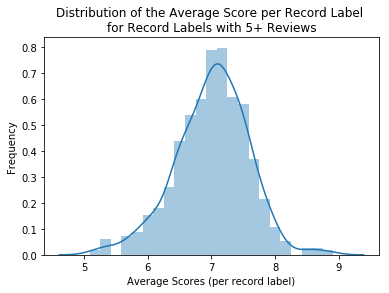

In [19]:
# Plotting the distribution of the average scores per record label with more
# than five reviews

sns.distplot(culled_label_df["avg_score"])
plt.xlabel("Average Scores (per record label)")
plt.ylabel("Frequency")
plt.title("Distribution of the Average Score per Record Label \n"
          + "for Record Labels with 5+ Reviews")
plt.show()

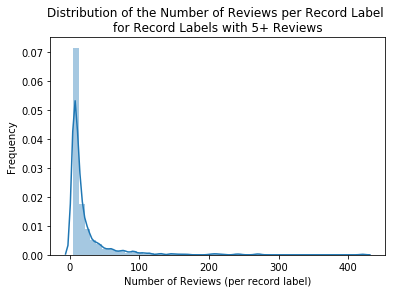

In [20]:
# Plotting the frequency of the number of reviews per record label with more
# than five reviews

sns.distplot(culled_label_df["count"])
plt.xlabel("Number of Reviews (per record label)")
plt.ylabel("Frequency")
plt.title("Distribution of the Number of Reviews per Record Label \n"
          + "for Record Labels with 5+ Reviews")
plt.show()

## Comparing Effect Sizes

In order to examine the difference between one record label's average score and the overall average score, we need to find the effect size to put our record labels on the same scale to convey practical significance.

Given that we know the sample size for each record label, from the 'count' column, we can examine what our minimum effect size should be to show significance for each record label, provided that we want an alpha of .01 and a power of 80%:

In [21]:
# Using TTestPower from the statsmodels.stats.power library
tt_test = TTestPower()

# Creating an empty dictionary for our necessary effect sizes
dict_needed_effects = {}

# Iterating through labels to add values to our needed effects dictionary
for label in culled_label_df.index:
    # Getting the sample size per record label, since each sample is 
    sample_size = culled_label_df.loc[label]["count"]
    
    # Leaving the effect_size variable in solve_power() as None, so the 
    # function solves for effect size
    needed_effect_size = tt_test.solve_power(
        nobs=sample_size, alpha=.01, power=.8, alternative="two-sided")

    dict_needed_effects[label] = needed_effect_size

In [22]:
# Sorting so we can see the smallest and largest necessary effect sizes
sorted_needed_effects = sorted(
    dict_needed_effects.items(), key=operator.itemgetter(1))
print(sorted_needed_effects[0][1])
print(sorted_needed_effects[-1][1])

0.16741780628417785
2.62897413958625


As you can see, there is quite the range in the effect size needed to show significance per record label. This is because the sample size for each record label is quite different - while we created the cutoff so we are only looking at record labels with at least five reviews, our maximum number of reviews is 420, giving us a pretty wide sample size range.

So let's look at the actual effect size for each record label! We can calculate the actual effect size between each record label and total group of all record labels with at least five reviews with the formula:

 $$ d = \dfrac{\mu_1 - \mu_2}{\sqrt{\dfrac{\sigma_1^2 + \sigma_2^2}{2}}}$$  
 
Which can be read as: the standardized difference between our two groups is the difference in means divided by the pooled standard deviation, where the pooled standard deviation is the square root of the average of the squared standard deviations.

In context:

 $$ \text{standardized difference} = \dfrac{\text{average score for each record label}- \text{average score for all record labels with 5+ reviews}}{\sqrt{\dfrac{\text{standard deviation within each record label}^2 + \text{standard deviation for all record labels with 5+ reviews}^2}{2}}}$$  
 
Note that this will result some positive and some negative effect sizes, showing the direction of the effect per record label.

In [23]:
# Grabbing the overall average score for all albums associated with a record 
# label with at least five reviews
overall_mean = culled_label_df["avg_score"].mean()
# Grabbing the overall standard deviation for the same group
overall_std = culled_label_df["avg_score"].std()

print(overall_mean)
print(overall_std)

7.008526773798876
0.5769279276330926


In [90]:
# Creating an empty dictionary for our actual effect sizes
dict_effect_sizes = {}

# Iterating through labels to add values to our actual effects dictionary
for label in culled_label_df.index:
    
    #Calculating effect size from the above function
    effect_size = (culled_label_df.loc[label]["avg_score"] - overall_mean) / ((
        culled_label_df.loc[label]["stdev"]**2 + overall_std**2)/2)**.5
    
    dict_effect_sizes[label] = effect_size

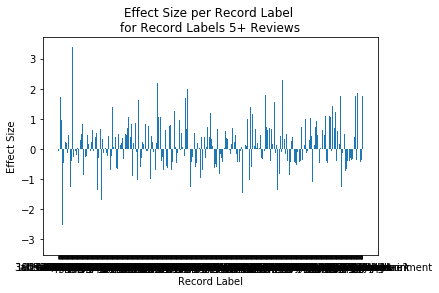

In [91]:
# Plotting our effect sizes, just out of curiousity
plt.bar(*zip(*dict_effect_sizes.items()))
plt.xlabel("Record Label")
plt.ylabel("Effect Size")
plt.title("Effect Size per Record Label \n"
          + "for Record Labels 5+ Reviews")
plt.show()

Because of our earlier work, we have a dictionary of the effect size needed per record label to prove a signicant difference between the overall population and the individual record label. Now, we have the actual effect size per record label. So, by comparing the actual effect size to the necessary effect size we can see which record labels have an actual significant difference:

In [92]:
# Creating a combined dictionary from the two individual dictionaries
dicts = [dict_needed_effects, dict_effect_sizes]
dict_combined_effects = {}
for k in dict_needed_effects.keys():
    dict_combined_effects[k] = tuple(d[k] for d in dicts)

In [93]:
# Creating a dataframe from the combined dictionary, for ease of use
effects_df = pd.DataFrame.from_dict(dict_combined_effects,
                                    orient="index",
                                    columns=["Needed Effect Size", 
                                             "Actual Effect Size"])
effects_df.head()

,Needed Effect Size,Actual Effect Size
!k7,0.435219,-0.068716
100% silk,1.595896,0.217521
1017 brick squad,1.801912,0.214991
12xu,2.628974,1.733499
130701,2.628974,0.639379


In [95]:
# Finding whether the actual effect size is greater than the effect size
# needed to show significance

# Note that we are using the absolute value of our actual effect sizes since
# the needed effect size is always positive, but the actual effect size can be
# either positive or negative (showing the direction of the effect)

# Creating empty lists for our differences and significances
difference = []
significant = []

for label in effects_df.index:
    # Calculating the difference between needed and actual effect sizes
    diff = abs(effects_df.loc[label]["Actual Effect Size"]
                     ) - effects_df.loc[label]["Needed Effect Size"]
    difference.append(diff)
    
    # Creating booleans to show whether the actual effect size was greater 
    # than the necessary effect size
    if diff > 0:
        sig = 1
    else:
        sig = 0
    significant.append(sig)

effects_df["Difference"] = difference
effects_df["Significant"] = significant

In [96]:
effects_df.head(10)

,Needed Effect Size,Actual Effect Size,Difference,Significant
!k7,0.435219,-0.068716,-0.366503,0
100% silk,1.595896,0.217521,-1.378375,0
1017 brick squad,1.801912,0.214991,-1.586922,0
12xu,2.628974,1.733499,-0.895475,0
130701,2.628974,0.639379,-1.989595,0
20 buck spin,1.166192,1.740854,0.574662,1
20/20/20,2.109349,0.587758,-1.521591,0
2062,2.109349,0.966114,-1.143235,0
300 entertainment,2.109349,1.142310,-0.967038,0
429,2.109349,-2.541961,0.432612,1


In [97]:
# Creating a new dataframe with only the record labels with a statistically
# significant difference between their average scores and the overall average
significant_difference = effects_df.loc[effects_df["Significant"] == 1]
significant_difference.head()

,Needed Effect Size,Actual Effect Size,Difference,Significant
20 buck spin,1.166192,1.740854,0.574662,1
429,2.109349,-2.541961,0.432612,1
4ad,0.308555,0.377452,0.068897,1
analog africa,2.109349,3.378591,1.269243,1
astralwerks,0.279338,-0.475588,0.196250,1


In [98]:
significant_difference.shape

(70, 4)

So there are 70 record labels with average scores that are significantly different than the overall average score!

Let's dig into what those record labels look like:

In [99]:
# Joining the average score, count and standard deviation columns from the 
# culled_label_df to the significant labels dataframe for more context
significant_labels_df = significant_difference.join(culled_label_df, 
                                                    how ="left")
significant_labels_df.head()

,Needed Effect Size,Actual Effect Size,Difference,Significant,avg_score,count,stdev
20 buck spin,1.166192,1.740854,0.574662,1,7.783333,12,0.251661
429,2.109349,-2.541961,0.432612,1,5.400000,6,0.684105
4ad,0.308555,0.377452,0.068897,1,7.370635,126,1.227946
analog africa,2.109349,3.378591,1.269243,1,8.516667,6,0.256255
astralwerks,0.279338,-0.475588,0.196250,1,6.380392,153,1.776493


In [100]:
# Examining the record labels with the highest average score
significant_labels_df.sort_values("avg_score", ascending=False).head()

,Needed Effect Size,Actual Effect Size,Difference,Significant,avg_score,count,stdev
philips,2.109349,2.744868,0.635519,1,8.916667,6,0.796032
irs,1.801912,2.128269,0.326357,1,8.842857,7,1.073712
dust-to-digital,1.166192,3.181030,2.014838,1,8.733333,12,0.505125
analog africa,2.109349,3.378591,1.269243,1,8.516667,6,0.256255
hip-o select,0.792015,1.557625,0.765610,1,8.513636,22,1.238776


In [101]:
# Examining the record labels with the lowest average score
significant_labels_df.sort_values("avg_score", ascending=True).head()

,Needed Effect Size,Actual Effect Size,Difference,Significant,avg_score,count,stdev
shady,1.332031,-1.465552,0.133521,1,5.140000,10,1.708280
429,2.109349,-2.541961,0.432612,1,5.400000,6,0.684105
metropolis,2.628974,-3.192106,0.563132,1,5.400000,5,0.418330
dim mak,0.675020,-0.835979,0.160959,1,5.951724,29,1.692129
jade tree,0.572420,-0.613700,0.041280,1,6.105128,39,2.000256


In [130]:
# Examining the record labels with the greatest difference between the effect
# size needed to show significance and their actual effect size
significant_labels_df.sort_values("Difference", ascending=False).head()

,Needed Effect Size,Actual Effect Size,Difference,Significant,avg_score,count,stdev
dust-to-digital,1.166192,3.181030,2.014838,1,8.733333,12,0.505125
analog africa,2.109349,3.378591,1.269243,1,8.516667,6,0.256255
tzadik,0.752540,1.758720,1.006179,1,7.929167,24,0.463896
numero group,0.454025,1.396150,0.942125,1,7.878333,60,0.665899
paradise of bachelors,0.926527,1.790585,0.864058,1,7.923529,17,0.435215


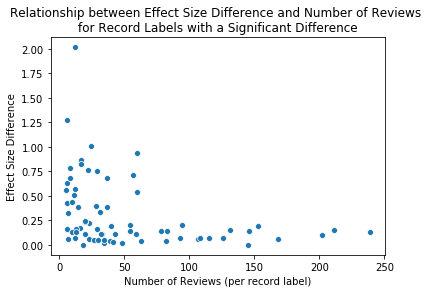

In [103]:
sns.scatterplot(x=significant_labels_df["count"], 
                y=significant_labels_df["Difference"])
plt.xlabel("Number of Reviews (per record label)")
plt.ylabel("Effect Size Difference")
plt.title("Relationship between Effect Size Difference and Number of Reviews \n"
          + "for Record Labels with a Significant Difference")
plt.show()

In [110]:
effect_mean = significant_labels_df["Actual Effect Size"].mean()

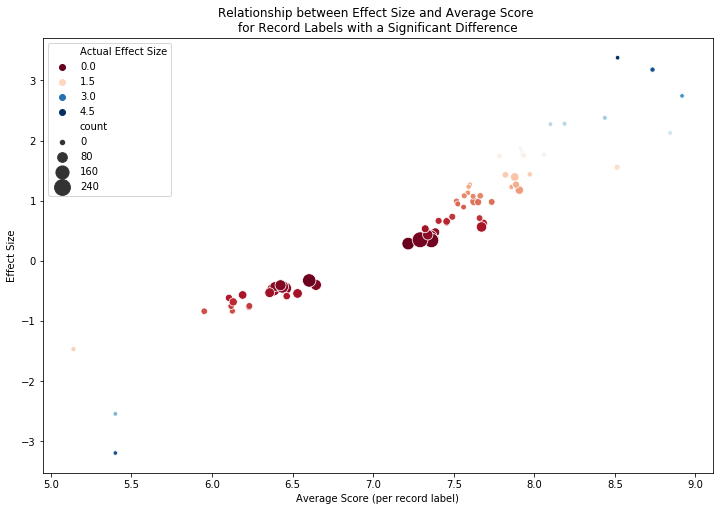

In [128]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=significant_labels_df["avg_score"],
                y=significant_labels_df["Actual Effect Size"],
                hue=(abs(significant_labels_df["Actual Effect Size"])),
                size=significant_labels_df["count"],
                sizes=(20,250),
                palette="RdBu")
plt.xlabel("Average Score (per record label)")
plt.ylabel("Effect Size")
plt.title("Relationship between Effect Size and Average Score \n"
          + "for Record Labels with a Significant Difference")
plt.show()

In [105]:
significant_scores_df = df[df["label"].isin(significant_labels_df.index)]
significant_scores_df.head()

,score,label
0,9.3,virgin
18,6.6,soul jazz
23,7.5,profound lore
25,7.8,northern spy
29,8.2,polyvinyl


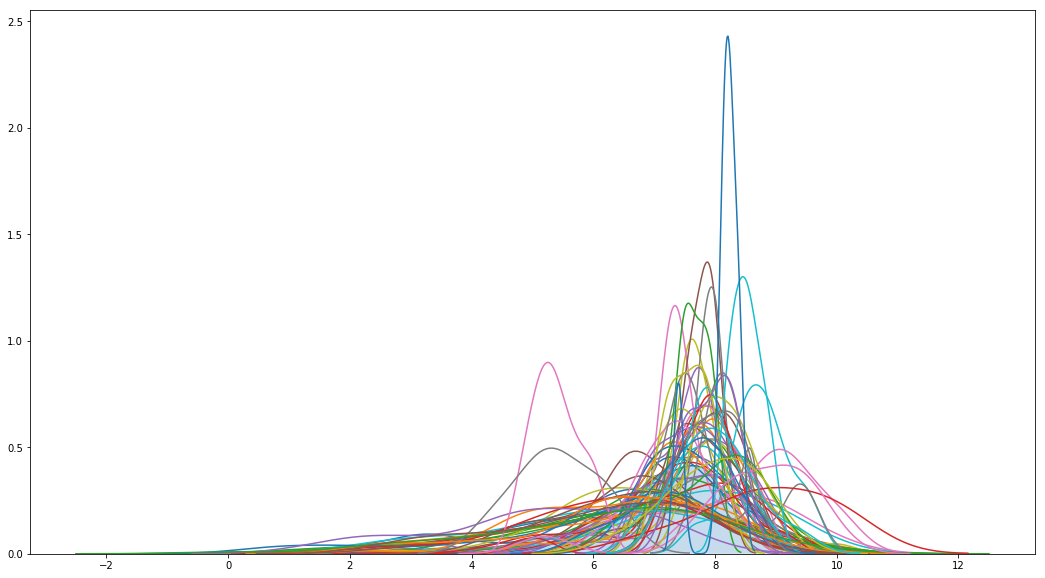

In [106]:
# Drawing an unfortunately useless graph showing
fig = plt.figure(figsize = (18,10))

sns.kdeplot(df["score"], shade=True, legend=False)

for label in significant_scores_df["label"].unique():
    label_df = significant_scores_df[significant_scores_df['label'] == label]
    sns.kdeplot(label_df["score"], legend=False)
    
plt.show()

We can see that there are 70 record labels whose average review scores are significantly different from the overall average review score for all record labels, according to our test which has a power of 80% and a 99% confidence level. This implies that the record label can have an effect on review score. 

A note on the limitations of this examination: other factors within the data could account for this effect. Record labels could only deal with one genre of music, for example, which could mean that an effect due to the genre is coming through as an effect due to record label. Other explanatory variables could be lurking behind record label and actually explaining the difference we found.